free blender model: https://free3d.com/3d-models/blender

In [1]:
import os
import sys
import torch
import pytorch3d
import numpy as np
from tqdm.notebook import tqdm

In [2]:
import os
import torch
import matplotlib.pyplot as plt

# Util function for loading meshes
from pytorch3d.io import load_objs_as_meshes, load_obj

# Data structures and functions for rendering
from pytorch3d.structures import Meshes
#from pytorch3d.vis.plotly_vis import AxisArgs, plot_batch_individually, plot_scene
from pytorch3d.vis.texture_vis import texturesuv_image_matplotlib
from pytorch3d.renderer import (
    look_at_view_transform,
    FoVPerspectiveCameras, 
    PointLights, 
    DirectionalLights, 
    Materials, 
    RasterizationSettings, 
    MeshRenderer, 
    MeshRasterizer,  
    SoftPhongShader,
    TexturesUV,
    TexturesVertex
)

# add path for demo utils functions 
import sys
import os
sys.path.append(os.path.abspath(''))
torch.cuda.is_available()

/home/joe/anaconda3/envs/pytorch3d/lib/python3.9/site-packages/pytorch3d/vis/__init__.py:14: UserWarning: Cannot import plotly-based visualization code. Please install plotly to enable (pip install plotly).
  warnings.warn(


True

In [3]:
#!wget https://raw.githubusercontent.com/facebookresearch/pytorch3d/main/docs/tutorials/utils/plot_image_grid.py
from plot_image_grid import image_grid

## 1. load mesh and texture file

In [4]:
#!mkdir -p data/cow_mesh
#!wget -P data/cow_mesh https://dl.fbaipublicfiles.com/pytorch3d/data/cow_mesh/cow.obj
#!wget -P data/cow_mesh https://dl.fbaipublicfiles.com/pytorch3d/data/cow_mesh/cow.mtl
#!wget -P data/cow_mesh https://dl.fbaipublicfiles.com/pytorch3d/data/cow_mesh/cow_texture.png

In [5]:
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    torch.cuda.set_device(device)
else:
    device = torch.device("cpu")

# Set paths
DATA_DIR = "./data"
obj_filename = os.path.join(DATA_DIR, "cow_mesh/cow.obj")

# Load obj file
#mesh = load_objs_as_meshes([obj_filename], device=device)

In [6]:
# let's try doing this without loading directly to mesh
verts, faces, aux = pytorch3d.io.load_obj(obj_filename, device=device)

textensor = list(aux.texture_images.values())[0][None].clone().to(device).detach().requires_grad_(True)
tex = pytorch3d.renderer.mesh.textures.TexturesUV(verts_uvs=[aux.verts_uvs.to(device)], faces_uvs=[faces.textures_idx.to(device)],
                                                  maps=textensor)
                                                 #maps=list(aux.texture_images.values())[0][None].to(device))
mesh = pytorch3d.structures.Meshes([verts], [faces.verts_idx], textures=tex)
textensor.requires_grad

True

In [7]:
def _mesh_from_textensor(t):
    textures = pytorch3d.renderer.mesh.textures.TexturesUV(verts_uvs=[aux.verts_uvs.to(device)], 
                                                          faces_uvs=[faces.textures_idx.to(device)],
                                                  maps=t)
    return pytorch3d.structures.Meshes([verts], [faces.verts_idx], textures=textures)

torch.Size([1, 1024, 1024, 3])


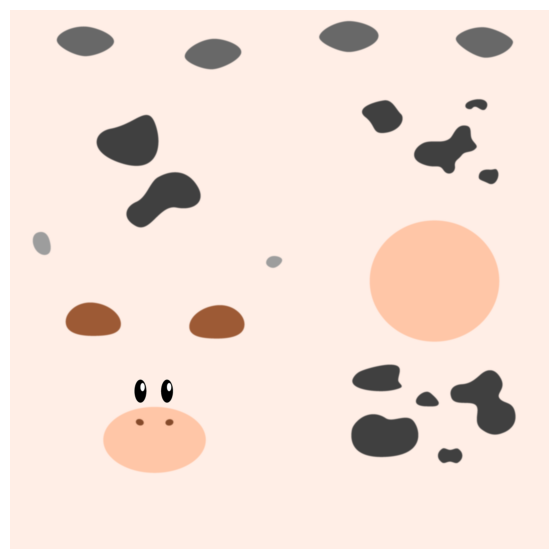

In [8]:
# visualize texture map
plt.figure(figsize=(7,7))
texture_image=mesh.textures.maps_padded()
print(texture_image.shape)
#plt.imshow(texture_image.squeeze().cpu().numpy())
plt.imshow(texture_image.squeeze().cpu().detach().numpy())
plt.axis("off");

In [9]:
len(mesh.textures.maps_list())

1

In [10]:
#plt.figure(figsize=(7,7))
#texturesuv_image_matplotlib(mesh.textures, subsample=None)
#plt.axis("off");

## 2. create a renderer

renderer has a **rasterizer** and a **shader**. those will need a camera and a light.

In [11]:
# Initialize a camera.
# With world coordinates +Y up, +X left and +Z in, the front of the cow is facing the -Z direction. 
# So we move the camera by 180 in the azimuth direction so it is facing the front of the cow. 
R, T = look_at_view_transform(2.7, 0, 180) 
cameras = FoVPerspectiveCameras(device=device, R=R, T=T)

# Define the settings for rasterization and shading. Here we set the output image to be of size
# 512x512. As we are rendering images for visualization purposes only we will set faces_per_pixel=1
# and blur_radius=0.0. We also set bin_size and max_faces_per_bin to None which ensure that 
# the faster coarse-to-fine rasterization method is used. Refer to rasterize_meshes.py for 
# explanations of these parameters. Refer to docs/notes/renderer.md for an explanation of 
# the difference between naive and coarse-to-fine rasterization. 
raster_settings = RasterizationSettings(
    image_size=512, 
    blur_radius=0.0, 
    faces_per_pixel=1, 
)

# Place a point light in front of the object. As mentioned above, the front of the cow is facing the 
# -z direction. 
lights = PointLights(device=device, location=[[0.0, 0.0, -3.0]])

# Create a Phong renderer by composing a rasterizer and a shader. The textured Phong shader will 
# interpolate the texture uv coordinates for each vertex, sample from a texture image and 
# apply the Phong lighting model
renderer = MeshRenderer(
    rasterizer=MeshRasterizer(
        cameras=cameras, 
        raster_settings=raster_settings
    ),
    shader=SoftPhongShader(
        device=device, 
        cameras=cameras,
        lights=lights
    )
)

## 3. render the mesh

include random camera parameters

torch.Size([1, 512, 512, 4])


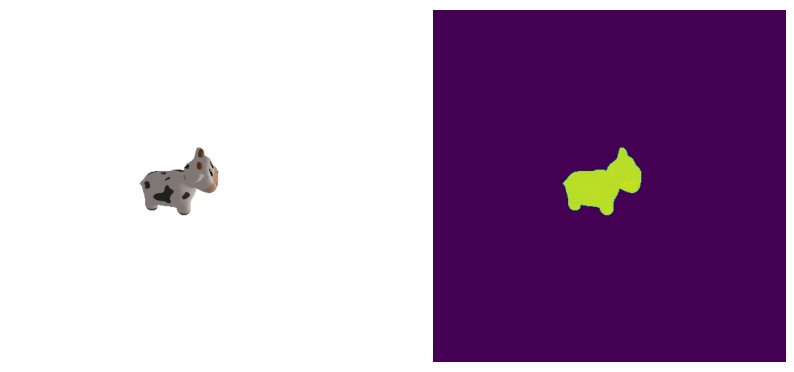

In [12]:
R, T = look_at_view_transform(dist=np.random.uniform(1,10), elev=np.random.uniform(0,90), azim=np.random.uniform(-180,180))
cameras = FoVPerspectiveCameras(device=device, R=R, T=T)

images = renderer(mesh, cameras=cameras)
print(images.shape)
plt.figure(figsize=(10, 10))
plt.subplot(121)
plt.imshow(images[0, ..., :3].cpu().detach().numpy())
plt.axis(False)
plt.subplot(122)
plt.imshow(images[0,:,:,3].cpu().detach().numpy())
plt.axis(False);

can i generate a batch of these?

from https://www.quora.com/What-is-the-difference-between-Ambient-Diffuse-and-Specular-Light-in-OpenGL-Figures-for-illustration-are-encouraged 

* Ambient light is the light that enters a room and bounces multiple times around the room before lighting a particular object. Ambient light contribution depends on the light’s ambient color and the ambient’s material color.
* Diffuse light represents direct light hitting a surface. The Diffuse Light contribution is dependent on the incident angle. For example, light hitting a surface at a 90 degree angle contributes more than light hitting the same surface at a 5 degrees.
* Specular light is the white highlight reflection seen on smooth, shinny objects. Specular light is dependent on the direction of the light, the surface normal and the viewer location.

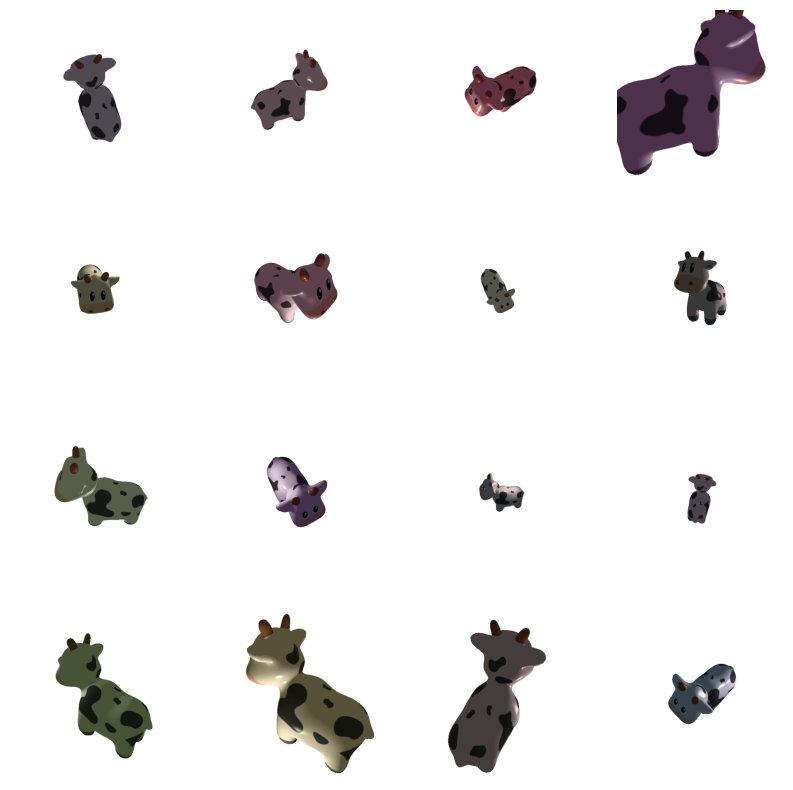

In [13]:
def sample_images(m, bs=16):
    R, T = look_at_view_transform(dist=np.random.uniform(1.5,6, size=bs), # had been 2,2 or 2,4
                              elev=np.random.uniform(0,90, size=bs), 
                              azim=np.random.uniform(-180,180, size=bs))
    cameras = FoVPerspectiveCameras(device=device, R=R, T=T)


    locations = np.random.normal(0, 1, size=(bs,3))
    locations /= np.expand_dims(np.sqrt((locations**2).sum(1)),-1)

    lights = PointLights(device=device, ambient_color=(np.random.uniform(0.2,0.4,size=(bs,3))),
            diffuse_color=(np.random.uniform(0.6,0.7,size=(bs,3))),
            specular_color=(np.random.uniform(0.4,0.6,size=(bs,3))),
            location=(locations))

    return renderer(m.extend(bs), cameras=cameras, lights=lights)

images = sample_images(mesh)
plt.figure(figsize=(10, 10))
for i in range(16):
    plt.subplot(4,4,i+1)
    plt.imshow(torch.clamp(images[i,:,:,:3], 0, 1).cpu().detach().numpy())
    plt.axis(False);

## classify rendered image

In [14]:
import torchvision

In [15]:
model = torchvision.models.resnet18(pretrained=True).eval().cuda()

In [16]:
classnames = eval( open("imagenet1000_clsidx_to_labels.txt", "r").read())
len(classnames)

1000

In [17]:
preds = model(images[:,:,:,:3].permute(0,3,1,2))
preds.shape

torch.Size([16, 1000])

In [18]:
[classnames[k] for k in preds.detach().cpu().numpy().argmax(1)]

['pick, plectrum, plectron',
 'hook, claw',
 'hair slide',
 'hook, claw',
 'hair slide',
 'hook, claw',
 'hair slide',
 'hook, claw',
 'hook, claw',
 'can opener, tin opener',
 'hair slide',
 'letter opener, paper knife, paperknife',
 'jigsaw puzzle',
 'lampshade, lamp shade',
 'can opener, tin opener',
 'can opener, tin opener']

In [19]:
#torch.nn.functional.nll_loss?

## FGSM attack

In [20]:
# FGSM attack code
# from https://pytorch.org/tutorials/beginner/fgsm_tutorial.html
def fgsm_attack(image, epsilon, data_grad):
    # Collect the element-wise sign of the data gradient
    sign_data_grad = data_grad.sign()
    # Create the perturbed image by adjusting each pixel of the input image
    perturbed_image = image + epsilon*sign_data_grad
    # Adding clipping to maintain [0,1] range
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    # Return the perturbed image
    return perturbed_image

In [21]:
classnames[2]

'great white shark, white shark, man-eater, man-eating shark, Carcharodon carcharias'

In [31]:
# https://pytorch.org/tutorials/beginner/fgsm_tutorial.html
num_steps = 500 #2000
bs = 32
epsilon = 1e-3 #0.01
targetclass = 2
print(f"target class {targetclass} ({classnames[targetclass]})")
y = targetclass*torch.ones(bs, dtype=torch.int32).type(torch.LongTensor).cuda()
accumulate = 1 #5

losses = []
pred_losses = []
diff_losses = []
accuracies = []
tex = textensor.clone().detach().requires_grad_(True)
assert tex.requires_grad
model.zero_grad()

for s in tqdm(range(num_steps)):
    # get mesh
    m = _mesh_from_textensor(tex)
    # generate new images
    x = sample_images(m, bs)[:,:,:,:3].permute((0,3,1,2))
    # run though the model
    pred = model(x)
    accuracies.append((pred.detach().cpu().numpy().argmax(1) == targetclass).mean()) 
    # zero existing gradients- should this be done on texture_image??
    model.zero_grad()
    # compute_loss
    pred_loss = torch.nn.functional.nll_loss(pred, y)
    diff_loss = (torch.sum((tex - textensor)**2))
    loss = pred_loss + 1e-4*diff_loss
    # backward pass to get gradients
    loss.backward()
    if s % accumulate == 0:
        # get gradient
        grad = tex.grad.data
        # run FGSM
        tex = fgsm_attack(tex, epsilon, -1*grad).detach().requires_grad_()
        losses.append(loss.detach().cpu().numpy())
        pred_losses.append(pred_loss.detach().cpu().numpy())
        diff_losses.append(diff_loss.detach().cpu().numpy())
        #model.zero_grad()
        #tex.zero_grad()


target class 2 (great white shark, white shark, man-eater, man-eating shark, Carcharodon carcharias)


  0%|          | 0/500 [00:00<?, ?it/s]

In [23]:
tex.requires_grad

True

In [29]:
model.zero_grad?

Signature: model.zero_grad(set_to_none: bool = False) -> None
Docstring:
Sets gradients of all model parameters to zero. See similar function
under :class:`torch.optim.Optimizer` for more context.

Args:
    set_to_none (bool): instead of setting to zero, set the grads to None.
        See :meth:`torch.optim.Optimizer.zero_grad` for details.
File:      ~/anaconda3/envs/pytorch3d/lib/python3.9/site-packages/torch/nn/modules/module.py
Type:      method

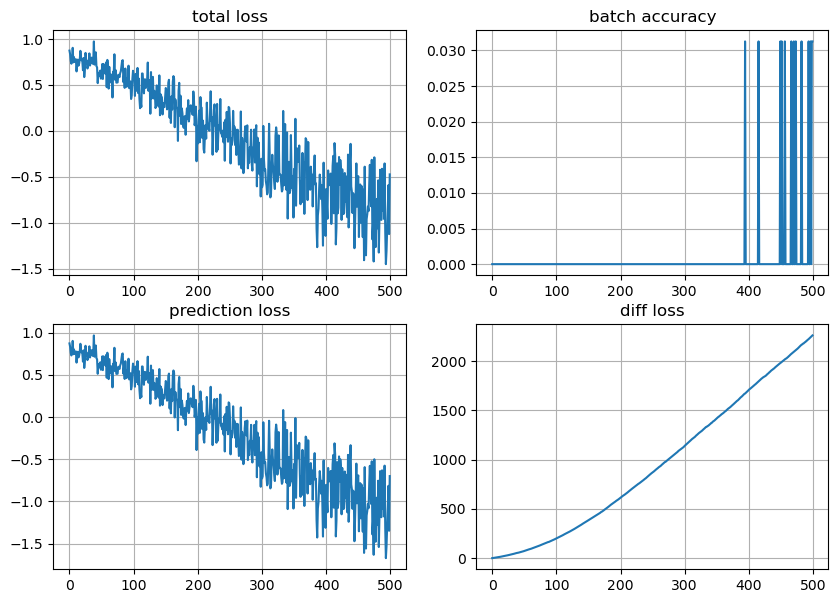

In [32]:
plt.figure(figsize=(10,7))
plt.subplot(221)
plt.plot(losses)
plt.title("total loss")
plt.grid(True)
plt.subplot(222)
plt.plot(accuracies)
plt.title("batch accuracy")
plt.grid(True)
plt.subplot(223)
plt.plot(pred_losses)
plt.title("prediction loss")
plt.grid(True)
plt.subplot(224)
plt.plot(diff_losses)
plt.title("diff loss")
plt.grid(True);

In [24]:
model(x).argmax(1)

tensor([  5,   2,   5, 623, 600, 792, 623,   2, 499,   2,   2, 499, 584,   2,
          2, 677,   5, 600, 600,   2, 677, 596, 623, 677, 600,   2,   5,   2,
          2, 623,   2, 792], device='cuda:0')

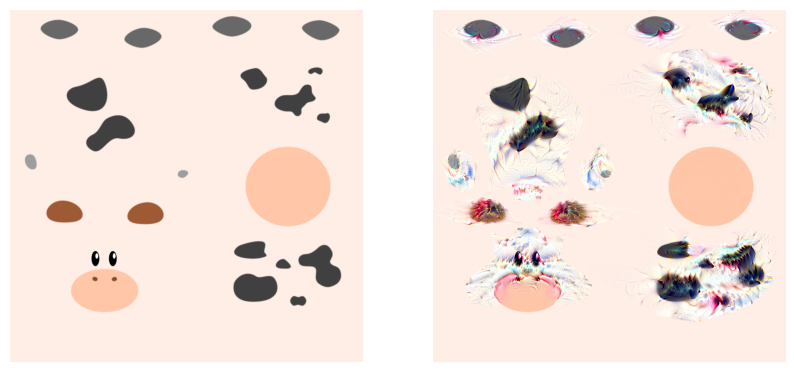

In [25]:
plt.figure(figsize=(10,5))
plt.subplot(121)
plt.imshow(textensor[0].detach().cpu().numpy())
plt.axis(False)
plt.subplot(122)
plt.imshow(tex[0].detach().cpu().numpy())
plt.axis(False);

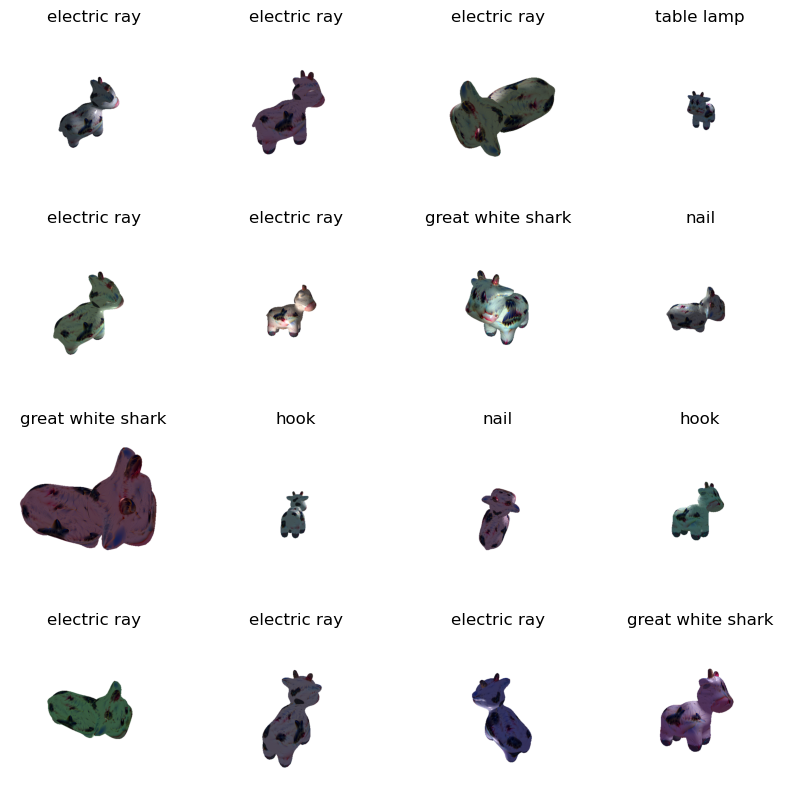

In [26]:
images = sample_images(_mesh_from_textensor(tex))[:,:,:,:3]
l = model(images.permute((0,3,1,2))).detach().cpu().numpy().argmax(1)
plt.figure(figsize=(10, 10))
for i in range(16):
    plt.subplot(4,4,i+1)
    plt.imshow(torch.clamp(images[i,:,:,:3], 0, 1).cpu().detach().numpy())
    plt.title(classnames[l[i]].split(",")[0])
    plt.axis(False);

In [28]:
textensor.is_leaf

True

In [44]:
m = _mesh_from_textensor(tex)
x = sample_images(m, bs)[:,:,:,:3].permute((0,3,1,2))
foo = torch.sum(x)

In [45]:
foo.backward()

In [46]:
tex.grad

AttributeError: 'Tensor' object has no attribute 'zero_grad'

In [ ]:
assert False

In [30]:

def attack_step(model, x, y, t, epsilon):
    """
    :x:
    :y:
    :t: texture map
    """
    # Accuracy counter
    correct = 0
    adv_examples = []
    
    for s in range(num_steps):
        # run examples through model
        pred = model(x)
        # zero existing gradients
        print("should i be zeroing grad in the texture map here?")
        model.zero_grad()
        # compute loss
        loss = torch.nn.functional.nll_loss(pred, y)
        # backward pass toget gradients
        loss.backward()
        # get gradient
        grad = t.grad.data
        # Call FGSM Attack
        perturbed_data = fgsm_attack(t, epsilon, data_grad)
        # STOPPED HERE
        # Reapply normalization
        perturbed_data_normalized = transforms.Normalize((0.1307,), (0.3081,))(perturbed_data)

        # Re-classify the perturbed image
        output = model(perturbed_data_normalized)


    # Loop over all examples in test set
    for data, target in test_loader:

        # Send the data and label to the device
        data, target = data.to(device), target.to(device)

        # Set requires_grad attribute of tensor. Important for Attack
        data.requires_grad = True

        # Forward pass the data through the model
        output = model(data)
        init_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability

        # If the initial prediction is wrong, don't bother attacking, just move on
        if init_pred.item() != target.item():
            continue

        # Calculate the loss
        loss = F.nll_loss(output, target)

        # Zero all existing gradients
        model.zero_grad()

        # Calculate gradients of model in backward pass
        loss.backward()

        # Collect ``datagrad``
        data_grad = data.grad.data

        # Restore the data to its original scale
        data_denorm = denorm(data)

        # Call FGSM Attack
        perturbed_data = fgsm_attack(data_denorm, epsilon, data_grad)

        # Reapply normalization
        perturbed_data_normalized = transforms.Normalize((0.1307,), (0.3081,))(perturbed_data)

        # Re-classify the perturbed image
        output = model(perturbed_data_normalized)

        # Check for success
        final_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
        if final_pred.item() == target.item():
            correct += 1
            # Special case for saving 0 epsilon examples
            if epsilon == 0 and len(adv_examples) < 5:
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )
        else:
            # Save some adv examples for visualization later
            if len(adv_examples) < 5:
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )

    # Calculate final accuracy for this epsilon
    final_acc = correct/float(len(test_loader))
    print(f"Epsilon: {epsilon}\tTest Accuracy = {correct} / {len(test_loader)} = {final_acc}")

    # Return the accuracy and an adversarial example
    return final_acc, adv_examples

## 4. move the light behind the object and re-render

In [31]:
print(lights.location)
# Now move the light so it is on the +Z axis which will be behind the cow. 
lights.location = torch.tensor([0.0, 0.0, +1.0], device=device)[None]
images = renderer(mesh, lights=lights)

tensor([[ 0.,  0., -3.]], device='cuda:0')


In [32]:
plt.figure(figsize=(10, 10))
plt.imshow(images[0, ..., :3].cpu().numpy())
plt.axis("off");

RuntimeError: Can't call numpy() on Tensor that requires grad. Use tensor.detach().numpy() instead.

<Figure size 1000x1000 with 0 Axes>

## 5. rotate the object, modify material properties or light properties

In [33]:
# Rotate the object by increasing the elevation and azimuth angles
R, T = look_at_view_transform(dist=2.7, elev=10, azim=-150)
cameras = FoVPerspectiveCameras(device=device, R=R, T=T)

# Move the light location so the light is shining on the cow's face.  
lights.location = torch.tensor([[2.0, 2.0, -2.0]], device=device)

# Change specular color to green and change material shininess 
materials = Materials(
    device=device,
    specular_color=[[0.0, 1.0, 0.0]],
    shininess=10.0
)

# Re render the mesh, passing in keyword arguments for the modified components.
images = renderer(mesh, lights=lights, materials=materials, cameras=cameras)
plt.figure(figsize=(10, 10))
plt.imshow(images[0, ..., :3].cpu().numpy())
plt.axis("off");

RuntimeError: Can't call numpy() on Tensor that requires grad. Use tensor.detach().numpy() instead.

<Figure size 1000x1000 with 0 Axes>

## 6. batched rendering

pretty much everything in pytorch3d can take batched inputs

In [ ]:
# Set batch size - this is the number of different viewpoints from which we want to render the mesh.
batch_size = 20

# Create a batch of meshes by repeating the cow mesh and associated textures. 
# Meshes has a useful `extend` method which allows us do this very easily. 
# This also extends the textures. 
meshes = mesh.extend(batch_size)

# Get a batch of viewing angles. 
elev = torch.linspace(0, 180, batch_size)
azim = torch.linspace(-180, 180, batch_size)

# All the cameras helper methods support mixed type inputs and broadcasting. So we can 
# view the camera from the same distance and specify dist=2.7 as a float,
# and then specify elevation and azimuth angles for each viewpoint as tensors. 
R, T = look_at_view_transform(dist=2.7, elev=elev, azim=azim)
cameras = FoVPerspectiveCameras(device=device, R=R, T=T)

# Move the light back in front of the cow which is facing the -z direction.
lights.location = torch.tensor([[0.0, 0.0, -3.0]], device=device)

# We can pass arbitrary keyword arguments to the rasterizer/shader via the renderer
# so the renderer does not need to be reinitialized if any of the settings change.
images = renderer(meshes, cameras=cameras, lights=lights)

image_grid(images.cpu().numpy(), rows=4, cols=5, rgb=True)

# adversarial attack prototyping

## load a pretrained model

In [34]:
import numpy as np
import torchvision

In [35]:
model = torchvision.models.resnet34(pretrained=True)
model(torch.Tensor(np.zeros((1, 3, 256, 256)).astype(np.float32))).shape

torch.Size([1, 1000])

get imagenet class names

In [36]:
!wget https://gist.githubusercontent.com/yrevar/942d3a0ac09ec9e5eb3a/raw/238f720ff059c1f82f368259d1ca4ffa5dd8f9f5/imagenet1000_clsidx_to_labels.txt

--2023-06-25 07:12:44--  https://gist.githubusercontent.com/yrevar/942d3a0ac09ec9e5eb3a/raw/238f720ff059c1f82f368259d1ca4ffa5dd8f9f5/imagenet1000_clsidx_to_labels.txt
Resolving gist.githubusercontent.com (gist.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.111.133, ...
Connecting to gist.githubusercontent.com (gist.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 30564 (30K) [text/plain]
Saving to: ‘imagenet1000_clsidx_to_labels.txt.1’

imagenet1000_clsidx 100%[===================>]  29.85K  --.-KB/s    in 0.03s   

2023-06-25 07:12:46 (1016 KB/s) - ‘imagenet1000_clsidx_to_labels.txt.1’ saved [30564/30564]



In [37]:
classnames = eval(open("imagenet1000_clsidx_to_labels.txt", "r").read())

In [38]:
classnames[5]

'electric ray, crampfish, numbfish, torpedo'

In [39]:
logits = model.cuda()(images[:,:,:,:3].permute(0,3,1,2))
logits.shape

torch.Size([1, 1000])

let's try putting the cow through and see what happens

In [40]:
i = 4
probs = torch.softmax(logits[i,:], 0).detach().cpu().numpy()
predclass = probs.argmax()
predname = classnames[predclass]
predprob = probs[predclass]
plt.imshow(images[i,:,:,:3].cpu().detach().numpy())
plt.title(f"{predname} ({str(round(predprob,3))[:5]})");

IndexError: index 4 is out of bounds for dimension 0 with size 1

In [ ]:



texture_image=mesh.textures.maps_padded()
print(texture_image.shape)

In [ ]:
# let's try reloading this in a way that gives us 
# the ability to pass gradients back through the
# texture map
DATA_DIR = "./data"
obj_filename = os.path.join(DATA_DIR, "cow_mesh/cow.obj")

verts, faces_idx, aux = load_obj(obj_filename)
print("verts:", verts.shape)
for i in range(len(faces_idx)):
    print(f"faces_idx {i}:", faces_idx[i].shape)
print("verts_idx:", faces_idx.verts_idx.shape)

In [ ]:
faces_idx.verts_idx.shape

In [ ]:
deform_verts = torch.full(verts.shape, 
                          0.0, device=device,
                          requires_grad=True)
sphere_verts_rgb = torch.full([1, verts.shape[0], 3], 0.8, 
                              device=device,
                              requires_grad=True)

In [ ]:
sphere_verts_rgb.grad

In [ ]:
deform_verts

In [ ]:
load_objs_as_meshes??

In [1]:
for i in range(10):
    print(i, i**2, round((i**2)/24,1))

0 0 0.0
1 1 0.0
2 4 0.2
3 9 0.4
4 16 0.7
5 25 1.0
6 36 1.5
7 49 2.0
8 64 2.7
9 81 3.4


In [3]:
64-48

16